In [55]:
import pandas as pd
import numpy as np
import time


dataset = pd.read_csv(r'hackathon_basketball_distribution.csv')

shotTypes = dataset.complexShotType.unique()
shotIds = [i for i in range(len(shotTypes))]

dataset['complexShotType'].replace(shotTypes, shotIds, inplace=True)

In [56]:
df1 = dataset.sample(frac=0.5, random_state=int(time.time()))
df2 = dataset.drop(df1.index)
dataset.head()


,player,season,fga3,fg3,period,startGameClock,shotClock,region,locX,locY,...,complexShotType,contestLevel,closestDefDist,rearViewContest,releaseTime,shotAngle,shooterSpeed,shooterVelAngle,rimDepth,rimLeftRight
0,"Murillo, Josue",2019,1,0,4,48.08,7.60,right wing three,-24.80,-18.64,...,0,lightly_contested,8.91,0,0.64,47.718662,0.131762,-66.153610,1.066764,-0.674009
1,"Castaneda, Urian",2019,1,1,4,37.42,1.80,right corner three,-44.74,-22.17,...,0,lightly_contested,8.34,0,0.84,97.680960,2.189780,13.513096,0.364760,0.096667
2,"Dean, Gregory",2021,1,1,2,297.60,8.36,middle three,-17.76,9.28,...,1,lightly_contested,6.96,0,1.20,-21.147858,1.133456,57.175232,1.681004,-0.661988
3,"Suazo, Garrett",2020,1,0,2,313.00,16.56,right wing three,-26.89,-20.08,...,1,uncontested,10.73,0,0.88,53.497086,2.296208,-41.983253,-0.663653,-0.857141
4,"Hatcher, Damian",2019,1,0,2,243.24,19.08,right wing three,-31.96,-22.33,...,1,uncontested,11.32,0,1.28,66.326220,1.166667,23.673782,-0.270286,0.182177


In [57]:
feature_cols = ['startGameClock', 'shotClock', 'distance', 'dribblesBefore', 'assistOpp', 'complexShotType', 'closestDefDist', 'rearViewContest', 'shotAngle', 'shooterSpeed', 'shooterVelAngle']
X = [df1.loc[:, feature_cols], df2.loc[:, feature_cols]]

Y = [df1['fg3'], df2['fg3']]

In [70]:
from sklearn import tree

clfs = [tree.DecisionTreeClassifier(), tree.DecisionTreeClassifier()] 

for i in range(len(clfs)):
    clfs[i] = clfs[i].fit(X[i], Y[i])

    
def getPredictedAndActualMade(clfs, x1, x2):
    sum1 = 0
    sum2 = 0
    if len(x2) > 0:
        sum1 = np.sum(clfs[0].predict(x2.loc[:, feature_cols]))
    if len(x1) > 0:
        sum2 = np.sum(clfs[1].predict(x1.loc[:, feature_cols])) 
    return  sum1 + sum2, np.sum(x1['fg3']) + np.sum(x2['fg3'])

In [71]:
predictions = np.zeros((2, X[0].shape[0]))
for i in range(len(clfs)):
    predictions[i] = clfs[i].predict(X[(i+1)%2])
    fg3Total = np.sum(predictions[i])/predictions[i].size*100
    print("For Model " + str(i + 1) + " " + str(fg3Total) + "% of the 3 pointers were made league wide.")

For Model 1 36.75725147845677% of the 3 pointers were made league wide.
For Model 2 36.90861729090397% of the 3 pointers were made league wide.


In [86]:
players = dataset.player.unique()
df = pd.DataFrame()
THRESHOLD = 200 # minimum predicted number of shots to be considered
base = 2
df['player_name'] = []
df['predicted_number_made'] = []
df['actual_number_made'] = []
df['percent_difference'] = []
df['fg%'] = []
df['attempts'] = []
df['metric'] = []

def write_to_dataframe(df, name, pred, actual, percentDifficulty, fg, attempts):
    metric = np.cbrt(attempts)*(fg + percentDifficulty)
    return df.append({'player_name' : name, 'predicted_number_made' : 
                        pred, 'actual_number_made' : actual, 
                        'percent_difference': percentDifficulty, 
                        'fg%' :  fg, 'attempts' : attempts, 'metric': metric}, 
                       ignore_index = True)

for player in players:
    pS = [df1[df1['player'] == player], df2[df2['player'] == player]]
    attemptedShots = len(pS[0]) + len(pS[1])
    if attemptedShots > THRESHOLD:
        predicted_total, actual_total = getPredictedAndActualMade(clfs, pS[0], pS[1])
        percentDifference = (actual_total - predicted_total)/predicted_total
        
        fgPercent = actual_total/attemptedShots
        
        df = write_to_dataframe(df, player, predicted_total, actual_total, percentDifference, fgPercent, attemptedShots)

In [88]:
df.sort_values(by = ['metric'], ascending=False).head(10)

,player_name,predicted_number_made,actual_number_made,percent_difference,fg%,attempts,metric
109,"Miramontes-Granillo, Andrew",340.0,424.0,0.247059,0.452026,938.0,6.843273
90,"Gibb-Morgan, Richard",643.0,737.0,0.146190,0.408763,1803.0,6.754420
151,"Yetemegn, Shaquille",568.0,634.0,0.116197,0.396250,1600.0,5.993619
184,"Collins, Damon",565.0,634.0,0.122124,0.383313,1654.0,5.977399
97,"Hurd, Eris",288.0,346.0,0.201389,0.439086,788.0,5.915767
137,"Sharp, Tayveon",360.0,414.0,0.150000,0.438095,945.0,5.771096
267,"Deherrera, Toby",281.0,336.0,0.195730,0.430769,780.0,5.767024
66,"Ney, Cory",319.0,375.0,0.175549,0.418527,896.0,5.727225
7,"Scott, Jante",487.0,539.0,0.106776,0.398669,1352.0,5.588981
81,"Whitaker, Timothy",369.0,419.0,0.135501,0.418581,1001.0,5.542674


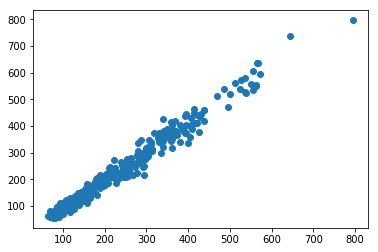

In [89]:
import matplotlib.pyplot as plt

predicted_made = df['predicted_number_made']
actual_made = df['actual_number_made']

plt.scatter(predicted_made, actual_made)